In [ ]:
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip install stable-baselines==2.5.1 box2d box2d-kengz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
libopenmpi-dev is already the newest version (2.1.1-8).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 0s (9,516 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 144793 files and dire

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import gym
import numpy as np

In [ ]:
#Neural network of PG
class PolicyGradientNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims=256, fc2_dims=256):
        super(PolicyGradientNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.pro = Dense(n_actions, activation='softmax')

    def call(self, state):
        value = self.fc1(state)
        value = self.fc2(value)

        pro = self.pro(value)

        return pro

#PG: REINFORCE
class REINFORCE:
    def __init__(self, alpha=0.005, gamma=0.99, n_actions=4,
                 layer1_size=256, layer2_size=256):

        self.gamma = gamma
        self.lr = alpha
        self.n_actions = n_actions
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.policy = PolicyGradientNetwork(n_actions=n_actions)
        self.policy.compile(optimizer=Adam(learning_rate=self.lr))

    def choose_action(self, observation):
        state = tf.convert_to_tensor([observation], dtype=tf.float32)
        probs = self.policy(state)
        action_probs = tfp.distributions.Categorical(probs=probs)
        action = action_probs.sample()

        return action.numpy()[0]

    def store_transition(self, observation, action, reward):
        self.state_memory.append(observation)
        self.action_memory.append(action)
        self.reward_memory.append(reward)

    def learn(self):
        actions = tf.convert_to_tensor(self.action_memory, dtype=tf.float32)
        rewards = np.array(self.reward_memory)

        G = np.zeros_like(rewards)
        for t in range(len(rewards)):
            G_sum = 0
            discount = 1
            for k in range(t, len(rewards)):
                G_sum += rewards[k] * discount
                discount *= self.gamma
            G[t] = G_sum

        with tf.GradientTape() as tape:
            loss = 0
            for idx, (g, state) in enumerate(zip(G, self.state_memory)):
                state = tf.convert_to_tensor([state], dtype=tf.float32)
                probs = self.policy(state)
                action_probs = tfp.distributions.Categorical(probs=probs)
                log_prob = action_probs.log_prob(actions[idx])
                loss += -g * tf.squeeze(log_prob)

        gradient = tape.gradient(loss, self.policy.trainable_variables)
        self.policy.optimizer.apply_gradients(zip(gradient, self.policy.trainable_variables))

        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []

In [ ]:
# n-step Sarsa with linear function approximation
def set_buckets_and_actions():
    number_of_buckets = (5, 5, 5, 5, 5, 5, 2, 2)  # buckets in each dimension
    number_of_actions = env.action_space.n

    # Creating a 2-tuple with the original bounds of each dimension
    state_value_bounds = list(zip(env.observation_space.low, env.observation_space.high))

    # New bound values for each dimension
    state_value_bounds[0] = [-1, 1]  # Position x
    state_value_bounds[1] = [-1, 1]  # Position y
    state_value_bounds[2] = [-1, 1]  # vel x
    state_value_bounds[3] = [-1, 1]  # vel y
    state_value_bounds[4] = [-1, 1]  # angle
    state_value_bounds[5] = [-1, 1]  # angular vel
    state_value_bounds[6] = [0, 1]
    state_value_bounds[7] = [0, 1]

    return number_of_buckets, number_of_actions, state_value_bounds


def bucketize(state):
    bucket_indexes = []
    for i in range(len(state)):
        if state[i] <= state_value_bounds[i][0]:
            bucket_index = 0
        elif state[i] >= state_value_bounds[i][1]:
            bucket_index = number_of_buckets[i] - 1
        else:
            bound_width = state_value_bounds[i][1] - state_value_bounds[i][0]
            offset = (number_of_buckets[i]-1) * state_value_bounds[i][0]/bound_width
            scaling = (number_of_buckets[i]-1) / bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indexes.append(bucket_index)
    return tuple(bucket_indexes)


def initialize_feature_table():
    return np.zeros(number_of_buckets + (number_of_actions,))

def initialize_w_table():
    return np.zeros(number_of_buckets + (number_of_actions,))

def linearapporox(q_table, w, bucket_state, action):
    # Initialize feature vector
    phi = initialize_feature_table()
    phi[bucket_state, action] = 1
    q_table[bucket_state, action] = w[bucket_state, action]*phi[bucket_state, action]

    return q_table


def initialize_q_table():
    return np.zeros(number_of_buckets + (number_of_actions,))


def choose_action(q_table, bucket_state, epsilon):
    if (np.random.random() <= epsilon):
        return env.action_space.sample() #Exploration
    else:
        return np.argmax(q_table[bucket_state]) #Eplotation


# Generate an episode following pi: S0, A0, R1, ...S_T-1,A_T-1,R_T
def Generate_episode(epsilon, q_table, max_env_steps):
    total_reward = 0
    done = False

    trayectory = []

    # Initialize S
    bucket_state = bucketize(env.reset())

    # Loop for each step of episode:
    for step in range(max_env_steps):
        # Choose A from S using epsilon-greedy derived from Q
        action = choose_action(q_table, bucket_state, epsilon)
        # Take the action A, observe R, S'
        new_state, reward, done, info = env.step(action)
        bucket_new_state = bucketize(new_state)
        trayectory.append([bucket_state, action, reward])
        bucket_state = bucket_new_state
        total_reward += reward

        if done:
            break

    return trayectory, total_reward


def nSarsa():
    # Initialize 𝑄(s,a) arbitrarily.
    q_table = initialize_q_table()

    # Initialize Weight
    w = initialize_w_table()

    rewards = []
    alpha = 0.03
    max_env_steps = env._max_episode_steps # 1000 in LunarLander

    # Loop for each episode:
    for episode in range(total_train_episodes):
        # print("\n\n ***Episode*** ", episode)

        # ******* Generate an episode following pi: S0, A0, R1, ...S_T-1,A_T-1,R_T
        epsilon = 0.1
        trayectory, total_reward = Generate_episode(epsilon, q_table, max_env_steps)

        G = 0

        # Loop for each step of episode: t = T-1, T-2, ..., 0
        for t in reversed(range(len(trayectory))):
            s_t, a_t, r_t = trayectory[t]
            G = gamma * G + r_t



        q_table = linearapporox(q_table, w, s_t, a_t)

        deta = G - q_table[s_t][a_t]

        w[s_t][a_t] += alpha * deta

        q_table = linearapporox(q_table, w, s_t, a_t)

        if episode % 1 == 0:
            rewards.append(total_reward)
            print("Episode {}, epsilon {:5.4f}, reward {:6.2f}".format(episode, epsilon, total_reward))

    print("Episode {}, epsilon {:5.4f}, reward {:6.2f}".format(episode, epsilon, total_reward))
    return q_table, rewards

流式输出内容被截断，只能显示最后 5000 行内容。
episode:  1001 score: -166.6 average score -83.2
episode:  1002 score: -96.9 average score -83.6
episode:  1003 score: -4.2 average score -82.7
episode:  1004 score: -76.5 average score -82.4
episode:  1005 score: -67.9 average score -82.4
episode:  1006 score: -43.0 average score -82.0
episode:  1007 score: -52.9 average score -81.9
episode:  1008 score: -69.5 average score -81.9
episode:  1009 score: -74.3 average score -81.6
episode:  1010 score: -47.0 average score -81.8
episode:  1011 score: -50.2 average score -79.8
episode:  1012 score: -70.5 average score -79.4
episode:  1013 score: -76.0 average score -79.8
episode:  1014 score: -25.1 average score -79.4
episode:  1015 score: -91.8 average score -79.6
episode:  1016 score: -149.5 average score -80.3
episode:  1017 score: -68.0 average score -80.2
episode:  1018 score: -80.5 average score -79.9
episode:  1019 score: -102.9 average score -79.5
episode:  1020 score: -32.3 average score -79.1
episode:  1

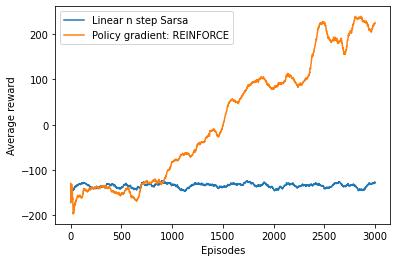

In [ ]:
if __name__ == '__main__':
    reinforce = REINFORCE(alpha=0.0005,  gamma=0.99,n_actions=4)

    env = gym.make('LunarLander-v2')
    score_history = []

    num_episodes = 3000

    for i in range(num_episodes):
        done = False
        score = 0
        observation = env.reset()
        while not done:
            action = reinforce.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            reinforce.store_transition(observation, action, reward)
            observation = observation_
            score += reward
        score_history.append(score)

        reinforce.learn()
        avg_score = np.mean(score_history[-100:])
        print('episode: ', i,'score: %.1f' % score,
            'average score %.1f' % avg_score)

    total_train_episodes = 3000
    gamma = 0.99
    epsilon = 0.1
    number_of_buckets, number_of_actions, state_value_bounds = set_buckets_and_actions()

    Sarsa_tables = []
    Sarsa_rewards = []

    q_table, rewards = nSarsa()
    Sarsa_tables.append(q_table)
    Sarsa_rewards.append(rewards)
    MC_mean = np.mean(np.array(Sarsa_rewards), axis=0)

    running_avg1 = []
    for t1 in range(total_train_episodes):
        running_avg1.append(np.mean(MC_mean[max(0, t1 - 100):(t1 + 1)]))

    plt.ylabel('Average reward')
    plt.xlabel('Episodes')

    x = np.linspace(0, total_train_episodes, MC_mean.size)
    plt.plot(x, running_avg1, label='Linear n step Sarsa')

    N = len(score_history)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(score_history[max(0, t - 100):(t + 1)])

    plt.plot(x, running_avg, label='Policy gradient: REINFORCE')
    plt.legend()
    plt.show()